<a href="https://colab.research.google.com/github/austinbennysmith/CMIP6/blob/main/plankton/EOF_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook will use **Empirical Orthogonal Functions** to learn about variability in the MODIS & VIIRS data at the [RIDDC ERDDAP server](https://pricaimcit.services.brown.edu/erddap/index.html). It will do the following:


*   Separately for the two satellites, map the EOFs and plot the Principal Components and Scree Plots for chlorophyll a, k490, or PAR against time
*   Plot the Principal Components for the two satellites together for chlorophyll a, k490, or PAR
*   Plot the first and second Principal Compnents against each other for any of the variables measured by the two satellites

This code uses the Python module eofs. The documentation and examples provided at [this link](https://ajdawson.github.io/eofs/latest/) were very helpful to me (I'm using the standard interface).

Currently, this notebook only works with monthly data. However, the code runs pretty quickly and could pretty easily be adapted to work with the 8 Day or 1 Day composites.

In [ ]:
#First, some installations and imports:
!pip install eofs
from eofs.standard import Eof
!pip install netCDF4
import requests
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
pd.options.display.max_columns = 25
#To use cartopy in a Colab notebook, I need a particular sequence of installs (as shown at this notebook: https://colab.research.google.com/github/adamlamee/CODINGinK12/blob/master/notebooks/quakes.ipynb#scrollTo=3LkZkXvnMAr4)
!apt-get -qq install python-cartopy python3-cartopy;
!pip uninstall -y shapely;
!pip install shapely --no-binary shapely;
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh
import calendar
import datetime
from scipy import stats

The following cell first asks you to choose whether to analyze chlorophyll, k490,  or PAR. It then loops through the MODIS and VIIRS monthly datasets associated with that variable and graphs the EOFs and Principal Components for each separately. It also produces scree plots that show how much of the variation is accounted for by each mode.

**Possible extension of what I'm doing here:** do EOF analysis of the anomaly from the climatological norm, rather than just looking at total variation

Would you like to graph Chlorophyll, k490, or par?Chlorophyll


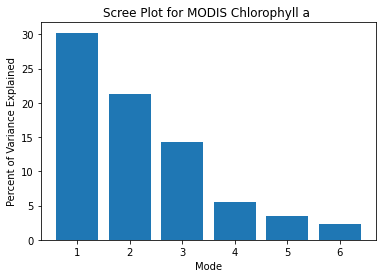

/usr/lib/python3/dist-packages/cartopy/io/__init__.py:264: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/10m/physical/ne_10m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


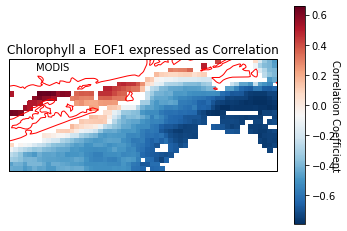

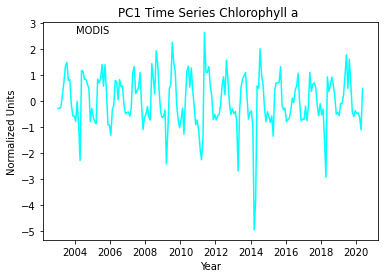

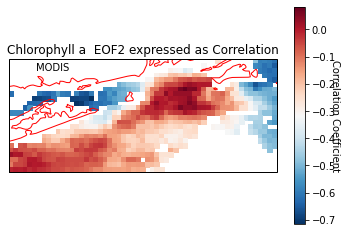

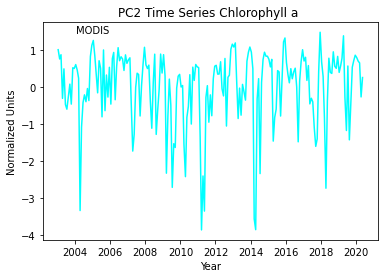

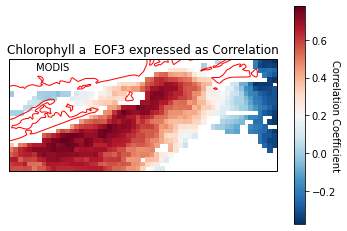

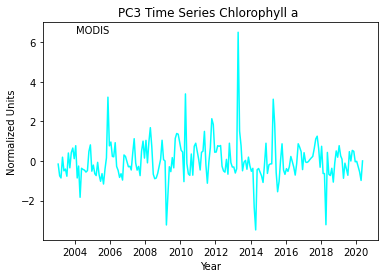

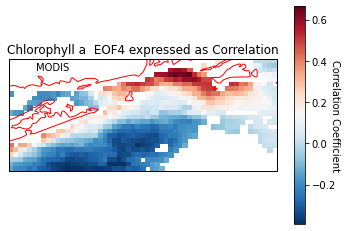

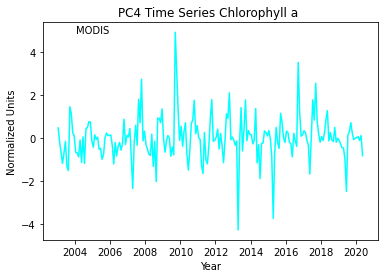

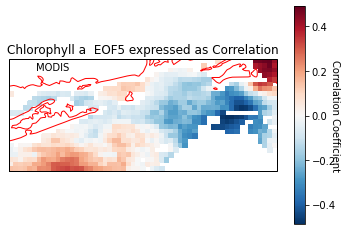

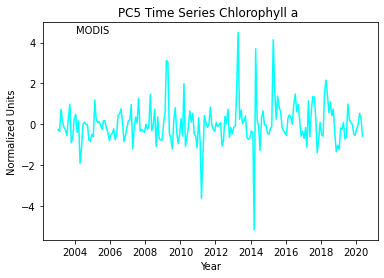

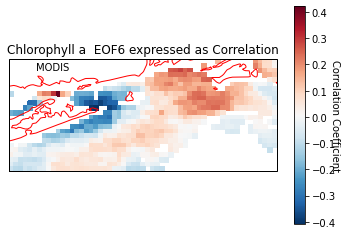

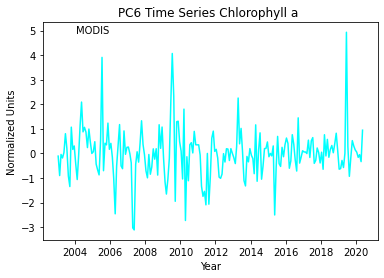

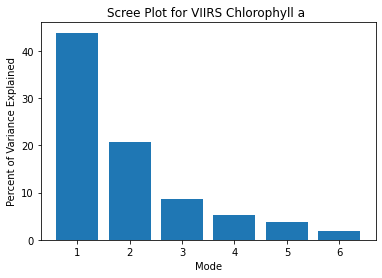

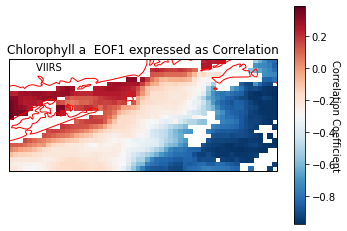

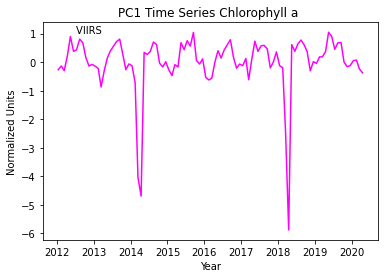

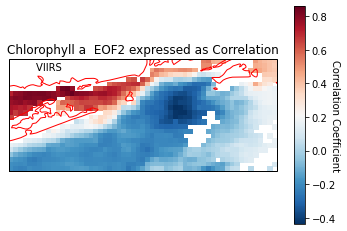

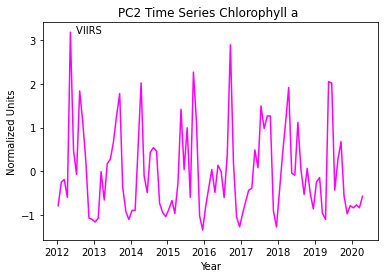

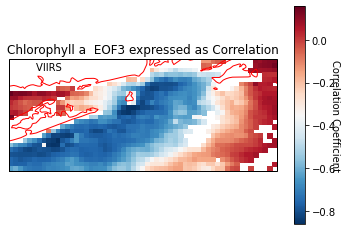

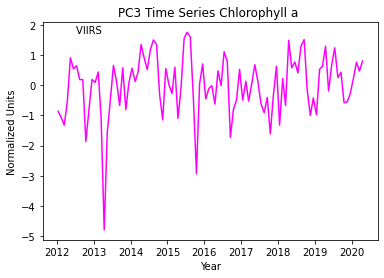

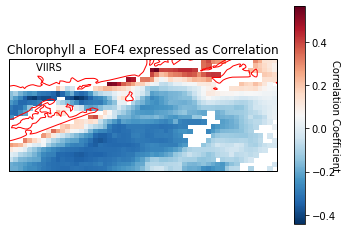

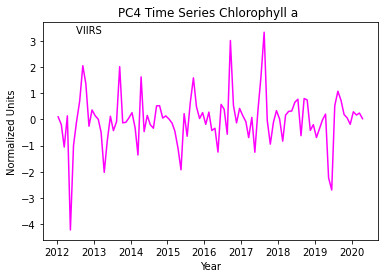

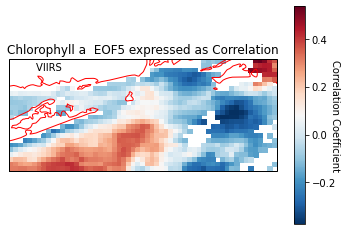

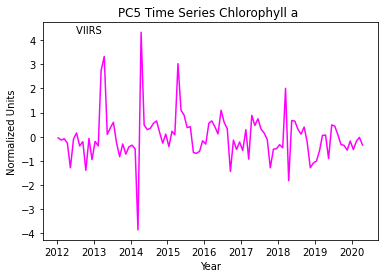

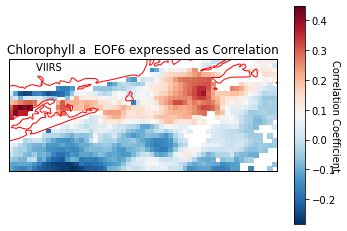

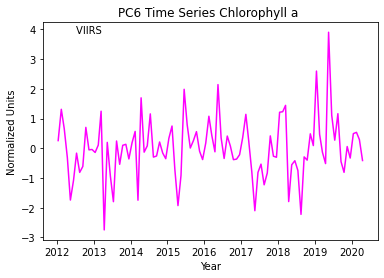

In [2]:
#from google.colab import drive
#drive.mount('/content/gdrive')
from netCDF4 import Dataset as NetCDFFile
import numpy as np
from datetime import date
from datetime import datetime as dt
#The following dictionary lists the monthly datasets for each of the possible variables to analyze:
monthly_data_dict = {
    'Chlorophyll':['erdMH1chlamday', 'erdVH2018chlamday'],
    'k490':['erdMH1kd490mday', 'erdVH2018k490mday'],
    'par':['erdMH1par0mday', 'erdVH2018parmday']
}
variable = input('Would you like to graph Chlorophyll, k490, or par?') #choosing which variable to analyze
tt = 'monthly' #Right now I only have this working for the monthly data
timearray = []
for k in monthly_data_dict[variable]: #looping through both datasets associated with the variable being analyzed
  #The following conditionals define some variables that are useful for generating the url and labeling plots:
  if variable == 'Chlorophyll':
    if 'MH' in k:
      myvar = 'chlorophyll'
      start_date = date(2003, 1, 16) #pick whichever starting date you want
      end_date = date(2020, 5, 16) #ending date can be changed as the dataset is updated
      thecolor = 'cyan' #I like to plot MODIS as cyan and VIIRS as magenta
      satellite = 'MODIS '
    elif 'VH' in k:
      myvar = 'chla'
      start_date = date(2012, 1, 15)
      end_date = date(2020, 4, 15)
      satellite = 'VIIRS '
      thecolor = 'magenta'
    unit = 'mg m^-3'
    title = 'Chlorophyll a '
  elif variable == 'k490':
    if 'MH' in k:
      myvar = 'k490'
      satellite = 'MODIS '
      start_date = date(2003, 1, 16)
      end_date = date(2020, 5, 16)
      thecolor = 'cyan'
    elif 'VH' in k:
      myvar = 'k490'
      satellite  = 'VIIRS '
      start_date = date(2012, 1, 15)
      end_date = date(2020, 4, 15)
      thecolor = 'magenta'
    unit = 'm^-1'
    title = 'K490 '
  elif variable == 'par':
    if 'MH' in k:
      satellite = 'MODIS '
      start_date = date(2003, 1, 16)
      end_date = date(2020, 5, 16)
      thecolor = 'cyan'
    elif 'VH' in k:
      satellite = 'VIIRS '
      start_date = date(2012, 1, 15)
      end_date = date(2020, 4, 15)
      thecolor = 'magenta'
    myvar = 'par'
    unit = 'einstein m^-2 day ^-1'
    title = 'Photosynthetically Available Radiation '
  #making the url and opening the dataset:
  url = 'https://pricaimcit.services.brown.edu/erddap/griddap/'+k+'.nc?'+myvar+'[('+str(start_date)+'):1:('+str(end_date)+')][(41.5):1:(40.5)][(-72.65):1:(-70.25)]'
  r = requests.get(url, allow_redirects=True)
  open('test.nc', 'wb').write(r.content)
  nc = NetCDFFile('test.nc')
  nc
  #defining data variables:
  lat = nc.variables['latitude'][:]
  lon = nc.variables['longitude'][:]
  time = nc.variables['time'][:]
  mapvar = nc.variables[myvar][:]
  coslat = np.cos(np.deg2rad(lat)).clip(0., 1.) #setting up weighting in the Eof
  wgts = np.sqrt(coslat)[..., np.newaxis]
  solver = Eof(mapvar, weights = wgts) #creating the Eof solver
  eof1 = solver.eofsAsCorrelation(neofs=6) #generating the EOFs. I'm using AsCorrelation for this, but you can also use AsCovariance
  pc1 = solver.pcs(npcs=6, pcscaling=1) #generating the Principal Components (change npcs if you want). By the way,  I'm not sure. what pscaling=1 means. I got this line from this page on the documentation website: https://ajdawson.github.io/eofs/latest/examples/elnino_standard.html
  vF1 = solver.varianceFraction(neigs=6) #computing the variance fractions (to be used when making the scree plot)
  percentarray = vF1*100 #the variance fractions are decimals. I'd like them to be percents.
  array1 = [1,2,3,4,5,6] #I computed variance Fraction for 6 modes, so I'll plot them against this list
  #images_dir = '/content/gdrive/Shared drives/BFK_BOG/SURF_UG/Benny/Images/Phytoplankton_averages/EOF Analyses/'+title[:-1]
  plt.bar(array1, percentarray) #making the scree plot
  plt.title('Scree Plot for '+satellite+title)
  plt.xlabel('Mode')
  plt.ylabel('Percent of Variance Explained')
  #plt.savefig(f"{images_dir}/Scree Plot "+myvar+" "+satellite+".png")
  plt.show()
  #making a list of times that is more amenable to graphing:
  timearray = []
  for i in time:
    timearray.append(dt.fromtimestamp(i))
  for i in range(6): #looping through 6 modes
    fig, ax = plt.subplots()
    #putting coastlines on my maps of the EOFs:
    ax = plt.axes(projection = ccrs.PlateCarree())
    ax.coastlines(resolution='10m', color = 'red')
    #mapping EOF i:
    myplot = plt.pcolormesh(lon, lat, eof1[i], cmap=plt.cm.RdBu_r)
    cbar = plt.colorbar()
    cbar.set_label('Correlation Coefficient', rotation=270)
    plt.title(title+' EOF'+str(i+1)+' expressed as Correlation')
    plt.text(0.1, 0.9, satellite, transform = ax.transAxes)
    #plt.savefig(f"{images_dir}/EOF"+str(i+1)+" "+myvar+" "+satellite+".png")
    plt.show()
    fig, ax = plt.subplots()
    #graphing Principal Component i:
    plt.plot(timearray, pc1[:, i], color = thecolor) #since there are multiple Principal Components and multiple times, pc1 is 2-dimensional. Therefore by plotting pc1[:, i], I get just principal component i, but at all times. You can confirm this by printing pc1 and pc1[:, i] for 1 mode and 6 modes and comparing.
    plt.title('PC'+str(i+1)+' Time Series '+title)
    plt.xlabel('Year')
    plt.ylabel('Normalized Units')
    plt.text(0.1, 0.95, satellite, transform = ax.transAxes)
    #plt.savefig(f"{images_dir}/PC"+str(i+1)+" time series "+myvar+" "+satellite+".png")
    plt.show()

**Graphing Principal Components from the two satellites together against time**

Would you like to graph Chlorophyll, k490, or par?Chlorophyll


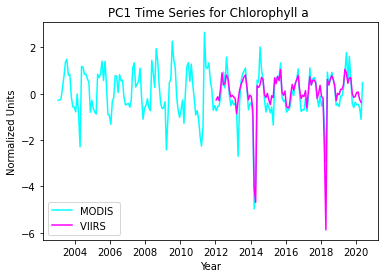

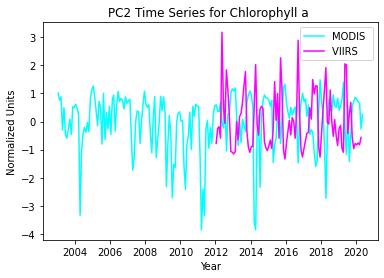

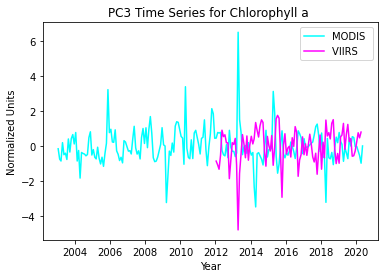

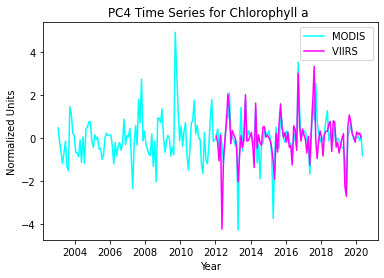

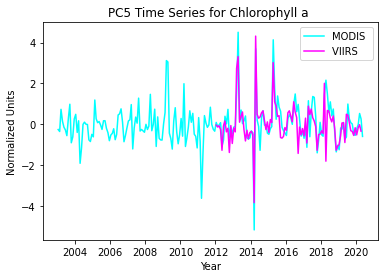

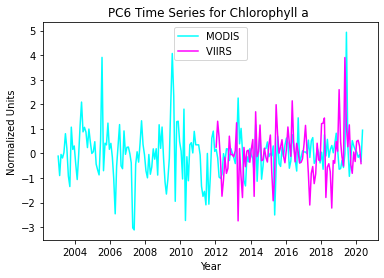

In [3]:
#from google.colab import drive
#drive.mount('/content/gdrive')
import numpy as np
from datetime import date
from datetime import datetime as dt
from netCDF4 import Dataset as NetCDFFile
#The following dictionary lists the monthly datasets for each of the possible variables to analyze:
monthly_data_dict = {
    'Chlorophyll':['erdMH1chlamday', 'erdVH2018chlamday'],
    'k490':['erdMH1kd490mday', 'erdVH2018k490mday'],
    'par':['erdMH1par0mday', 'erdVH2018parmday']
}
variable = input('Would you like to graph Chlorophyll, k490, or par?') #choosing which datasets to analyze
tt = 'monthly' #right now this only works for monthly composites
urls = {} #since I'm graphing for multiple datasets together, I'll need a dictionary of more than one url
def conditionals(data_id):
  #the global statements below will allow me to reference these variables outside of the conditionals function
  global myvar
  global title
  global unit
  global timearray
  global satellite
  global start_date
  global end_date
  global thecolor
  #defining some variables to help with plotting and making the url:
  if variable == 'Chlorophyll':
    if 'MH' in data_id:
      myvar = 'chlorophyll'
      start_date = date(2003, 1, 16)
      end_date = date(2020, 5, 16)
      satellite = 'MODIS '
      thecolor = 'cyan'
    elif 'VH' in data_id:
      myvar = 'chla'
      start_date = date(2012, 1, 15)
      end_date = date(2020, 4, 15)
      satellite = 'VIIRS '
      thecolor = 'magenta'
    unit = 'mg m^-3'
    title = 'Chlorophyll a '
  elif variable == 'k490':
    if 'MH' in data_id:
      myvar = 'k490'
      satellite = 'MODIS '
      start_date = date(2003, 1, 16)
      end_date = date(2020, 5, 16)
      thecolor = 'cyan'
    elif 'VH' in data_id:
      myvar = 'k490'
      satellite  = 'VIIRS '
      start_date = date(2012, 1, 15)
      end_date = date(2020, 4, 15)
      thecolor = 'magenta'
    unit = 'm^-1'
    title = 'K490 '
  elif variable == 'par':
    myvar = 'par'
    title = 'Photosynthetically Available Radiation '
    if 'MH' in data_id:
      satellite = 'MODIS '
      start_date = date(2003, 1, 16)
      end_date = date(2020, 5, 16)
      thecolor = 'cyan'
    elif 'VH' in data_id:
      satellite = 'VIIRS '
      start_date = date(2012, 1, 15)
      end_date = date(2020, 4, 15)
      thecolor = 'magenta'
for k in monthly_data_dict[variable]: #looping through all the datasets listed under the chosen variable in monthly_data_dict
  conditionals(k) #need to run the conditionals function for each dataset in order to generate the url correctly
  #below, I'm adding entries to the url dictionary. The "url{0}.format" piece allows me to name the dictionary keys using the loop variable.
  urls["url{0}".format(monthly_data_dict[variable].index(k)+1)] = 'https://pricaimcit.services.brown.edu/erddap/griddap/'+k+'.nc?'+myvar+'[('+str(start_date)+'):1:('+str(end_date)+')][(41.5):1:(40.5)][(-72.65):1:(-70.25)]'
#next I'll create a list of 2 url dictionaries. Each dictionary will correspond to one of the entries in urls, and will have keys for latitude, longitude, time, mapvar, and dataset_id. This will enable me to graph these things by referencing entries in the list of dictionaries later on.
firsturldict = {}
secondurldict = {}
urldictarray = [firsturldict, secondurldict]
for n in urls: #looping through the 2 entries in urls
  conditionals(monthly_data_dict[variable][list(urls).index(n)]) #need to run the conditionals using the nth entry of monthly_data_dict[variable] in order to open the url correctly and reference the variables in the dataset
  r = requests.get(urls[n], allow_redirects=True)
  open('test.nc', 'wb').write(r.content)
  nc = NetCDFFile('test.nc')
  nc
  #Below, I'm defining dataset variables and putting them in urldictarray
  urldictarray[list(urls).index(n)]['latitude'] = nc.variables['latitude'][:] #typing list(urls).index(n) allows me to put the MODIS data at index 0 in urldictarray, and to put the VIIRS data at index 1. This is because MODIS is the first entry in urls and VIIRS is the second entry. This matters because I would like to loop through the MODIS data first while plotting, in order to automatically get the color & labels correct within that for loop.
  urldictarray[list(urls).index(n)]['longitude'] = nc.variables['longitude'][:]
  time = nc.variables['time'][:]
  #making a list of times for plotting purposes
  timearray = []
  for v in time:
    timearray.append(dt.fromtimestamp(v))
  #defining some more dataset variables:
  urldictarray[list(urls).index(n)]['time'] = timearray
  urldictarray[list(urls).index(n)]['mapvar'] = nc.variables[myvar][:]
  urldictarray[list(urls).index(n)]['dataset_id'] = monthly_data_dict[variable][list(urls).index(n)]
#images_dir = '/content/gdrive/Shared drives/BFK_BOG/SURF_UG/Benny/Images/Phytoplankton_averages/EOF Analyses/'+title[:-1]
for u in range(6): #I'm going to do 6 modes
  graphingdict = {}
  plt.figure()
  for z in urldictarray: #looping through both datasets
    conditionals(z['dataset_id']) #need to run conditionals for z['dataset_id'] so that I can label plots correctly below.
    coslat = np.cos(np.deg2rad(z['latitude'])).clip(0., 1.) #weighting
    wgts = np.sqrt(coslat)[..., np.newaxis] #weighting
    solver = Eof(z['mapvar'], weights = wgts) #creating the EOF solver
    pc1 = solver.pcs(npcs=6, pcscaling=1) #defining the Principal Components. By the way,  I'm not sure. what pscaling=1 means. I got this line from this page on the documentation website: https://ajdawson.github.io/eofs/latest/examples/elnino_standard.html
    plt.plot(z['time'], pc1[:, u], label = satellite, color = thecolor) #plotting the uth Principal Component for dataset z
  plt.title('PC'+str(u+1)+' Time Series for '+title)
  plt.xlabel('Year')
  plt.ylabel('Normalized Units')
  plt.legend(loc='best')
  #plt.savefig(f"{images_dir}/Combined PC"+str(u+1)+" time series "+myvar+".png")
  plt.show()

The following cell will graph the **first and second Principal Components against each other**. For the variables captured by both satellites (Chlorophyll a, k490, and PAR), both are shown on the plots. However, all the variables captured by only one satellite are also plotted. Those variables are Fluorescence Line Height (cflh), Particulate Inorganic Carbon (pic), Particulate Organic Carbon (poc), and Reflectance at 671 nm (r671).

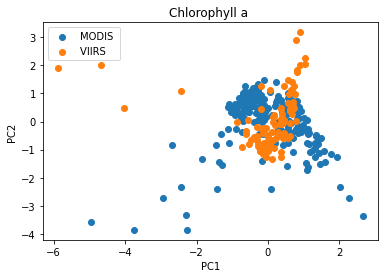

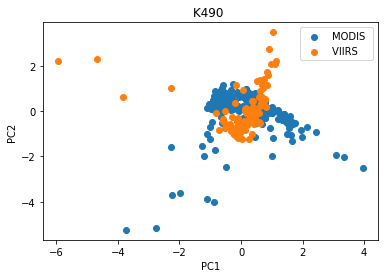

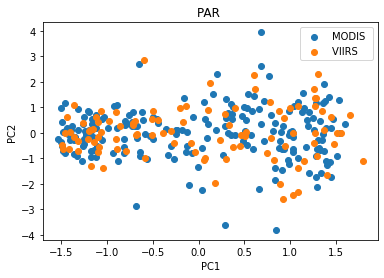

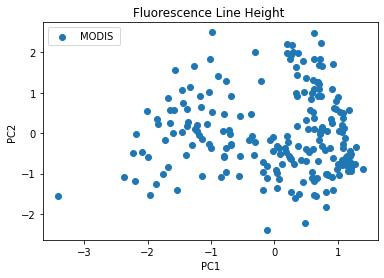

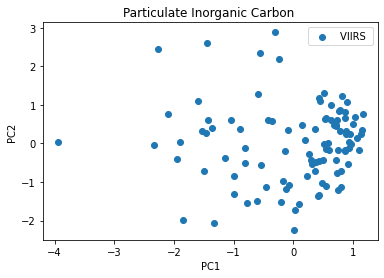

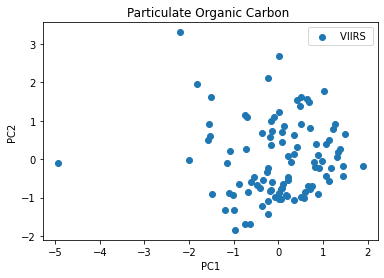

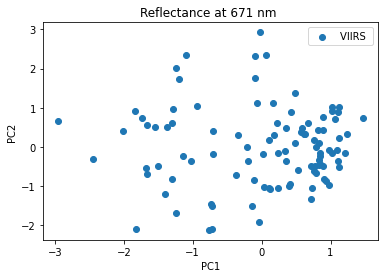

In [4]:
#from google.colab import drive
#drive.mount('/content/gdrive')
#mydirectory = '/content/gdrive/Shared drives/BFK_BOG/SURF_UG/Benny/Images/Phytoplankton_averages'
from netCDF4 import Dataset as NetCDFFile
import numpy as np
from datetime import date
from datetime import datetime as dt
import requests
import matplotlib
#The following dictionary lists the dataset IDs associated with each variable. This will allow me to loop through all the satellites that have data for the variable
monthly_data_dict ={
    'Chlorophyll':['erdMH1chlamday', 'erdVH2018chlamday'],
    'k490':['erdMH1kd490mday', 'erdVH2018k490mday'],
    'par':['erdMH1par0mday', 'erdVH2018parmday'],
    'cflh':['erdMH1cflhmday'],
    'pic':['erdVH2018picmday'],
    'poc':['erdVH2018pocmday'],
    'r671':['erdVH2018r671mday']
}
variableslist = ['Chlorophyll', 'k490', 'par', 'cflh', 'pic', 'poc', 'r671'] #creating a list of variables that I'll loop through
for variable in variableslist: #looping through all the variables
  tt = 'monthly' #just doing this for monthly data right now. Could update the program in the future to deal with 8 Day or 1 Day, in which case I would need some conditional statements to determine tt based on the dataset ID (I would also need to change the monthly_data_dict)
  #the following conditionals define some variables that are useful for plotting and creating the url, depending on which variable I'm trying to analyze and which satellite it comes from
  for k in monthly_data_dict[variable]:
    if 'MH' in k:
      start_date = date(2003, 1, 16)
      end_date = date(2020, 5, 16)
      thecolor = 'cyan'
      satellite = 'MODIS '
    elif 'VH' in k:
      start_date = date(2012, 1, 15)
      end_date = date(2020, 4, 15)
      satellite = 'VIIRS '
      thecolor = 'magenta'
    if variable == 'Chlorophyll':
      if 'MH' in k:
        myvar = 'chlorophyll'
      elif 'VH' in k:
        myvar = 'chla'
      unit = 'mg m^-3'
      title = 'Chlorophyll a '
    elif variable == 'k490':
      unit = 'm^-1'
      title = 'K490 '
      myvar = 'k490'
    elif variable == 'par':
      myvar = 'par'
      unit = 'einstein m^-2 day ^-1'
      title = 'PAR '
    elif variable == 'cflh':
      myvar = 'cflh'
      unit = 'W m^-2 um^-1 sr^-1'
      title = 'Fluorescence Line Height '
    elif variable == 'pic':
      myvar = 'pic'
      unit = 'mol m^-3'
      title = 'Particulate Inorganic Carbon '
    elif variable == 'poc':
      myvar = 'poc'
      unit = 'mg m^-3'
      title = 'Particulate Organic Carbon '
    elif variable == 'r671':
      myvar = 'r671'
      unit = 'sr^-1'
      title = 'Reflectance at 671 nm '
    #making the url and opening the dataset:
    url = 'https://pricaimcit.services.brown.edu/erddap/griddap/'+k+'.nc?'+myvar+'[('+str(start_date)+'):1:('+str(end_date)+')][(41.5):1:(40.5)][(-72.65):1:(-70.25)]'
    r = requests.get(url, allow_redirects=True)
    open('test.nc', 'wb').write(r.content)
    nc = NetCDFFile('test.nc')
    nc
    #defining some of the dataset variables:
    lat = nc.variables['latitude'][:]
    lon = nc.variables['longitude'][:]
    time = nc.variables['time'][:]
    mapvar = nc.variables[myvar][:]
    coslat = np.cos(np.deg2rad(lat)).clip(0., 1.) #weighting
    wgts = np.sqrt(coslat)[..., np.newaxis] #weighting
    solver = Eof(mapvar, weights = wgts) #making the Eof solver
    pc1 = solver.pcs(npcs=2, pcscaling=1) #solving for the Principal Components. By the way,  I'm not sure. what pscaling=1 means. I got this line from this page on the documentation website: https://ajdawson.github.io/eofs/latest/examples/elnino_standard.html
    plt.scatter(pc1[:, 0], pc1[:, 1], label=satellite) #pc1[:, 0] is the first principal component at all times, while pc1[:, 1] is the second principal component at all times
    plt.xlabel('PC1')
    plt.ylabel('PC2')
  plt.title(title)
  plt.legend(loc='best')
  #plt.savefig(f"{mydirectory}/"+variable+" PC_vs.png")
  plt.show()

Lastly, the following cell makes the same PC1 vs PC2 graphs as before, but connected by lines and arrows showing the direction of change over time. For most of the plots, it is difficult to see a pattern. However, the Fluorescence Line Height graph shows a clear pattern of circulation.


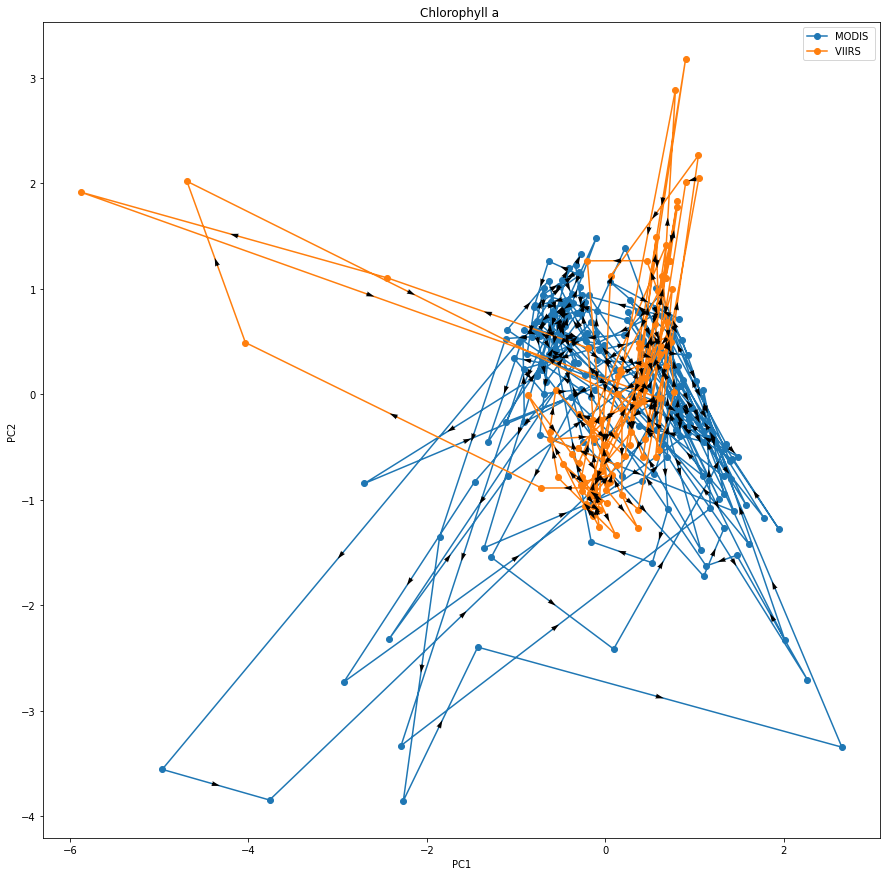

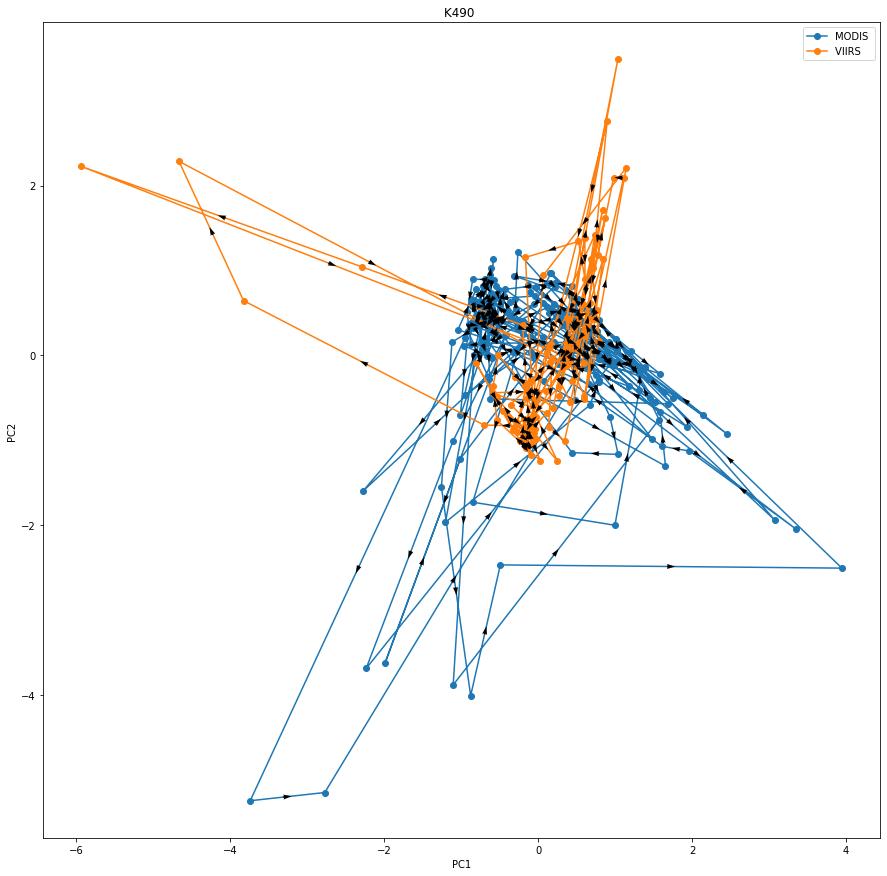

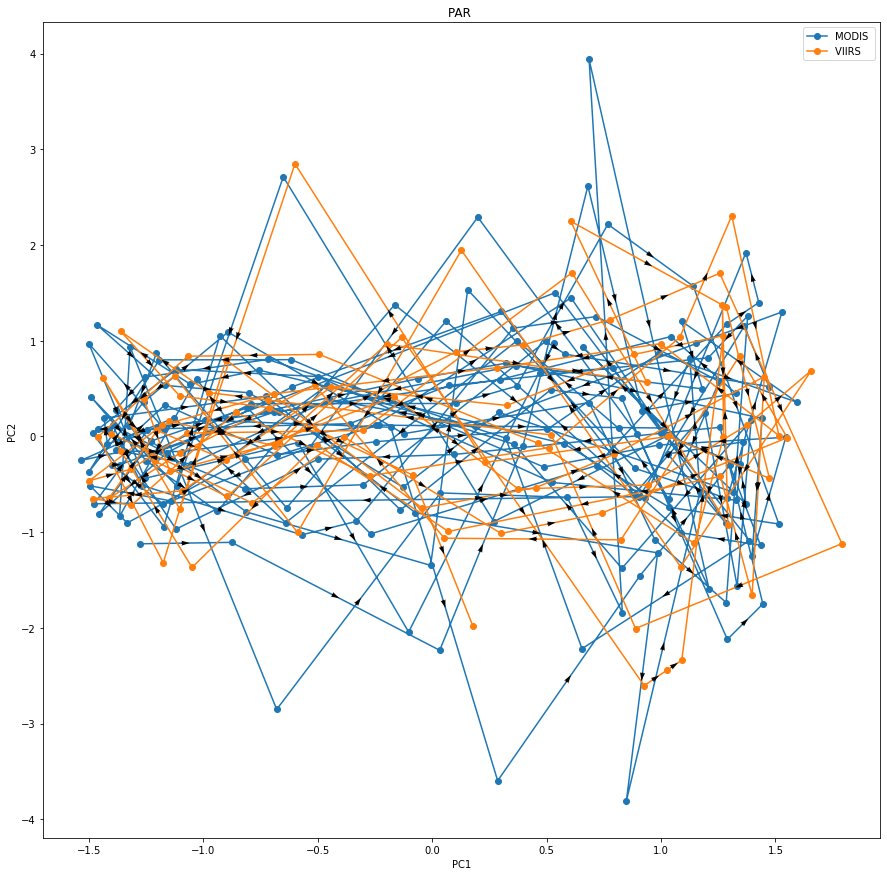

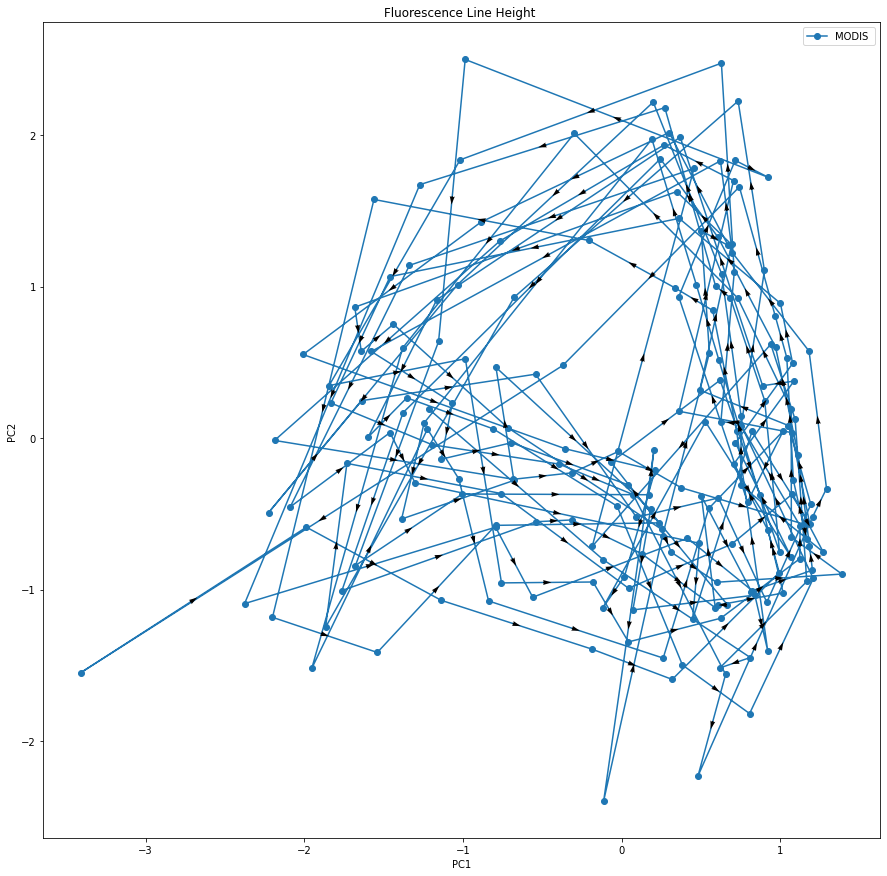

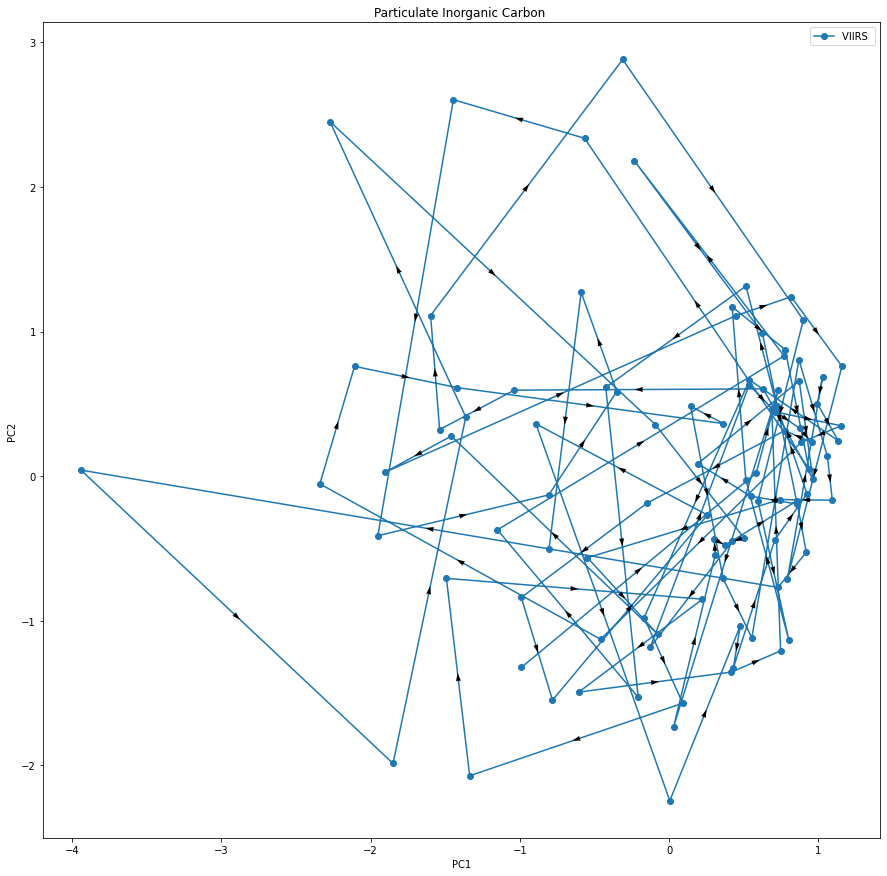

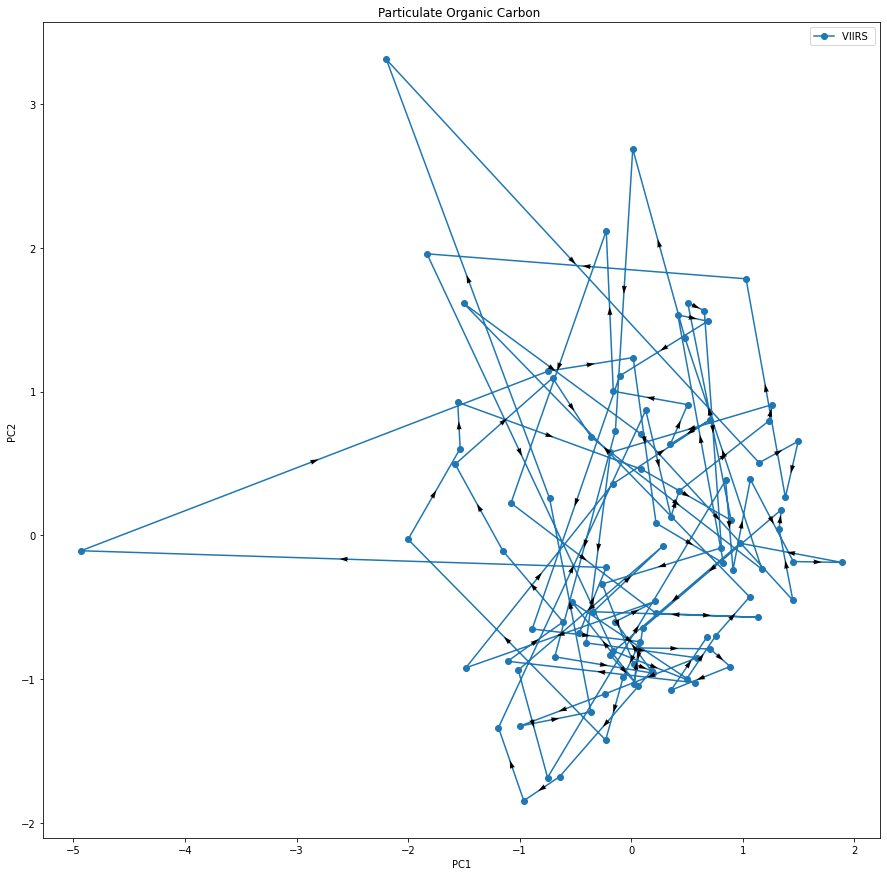

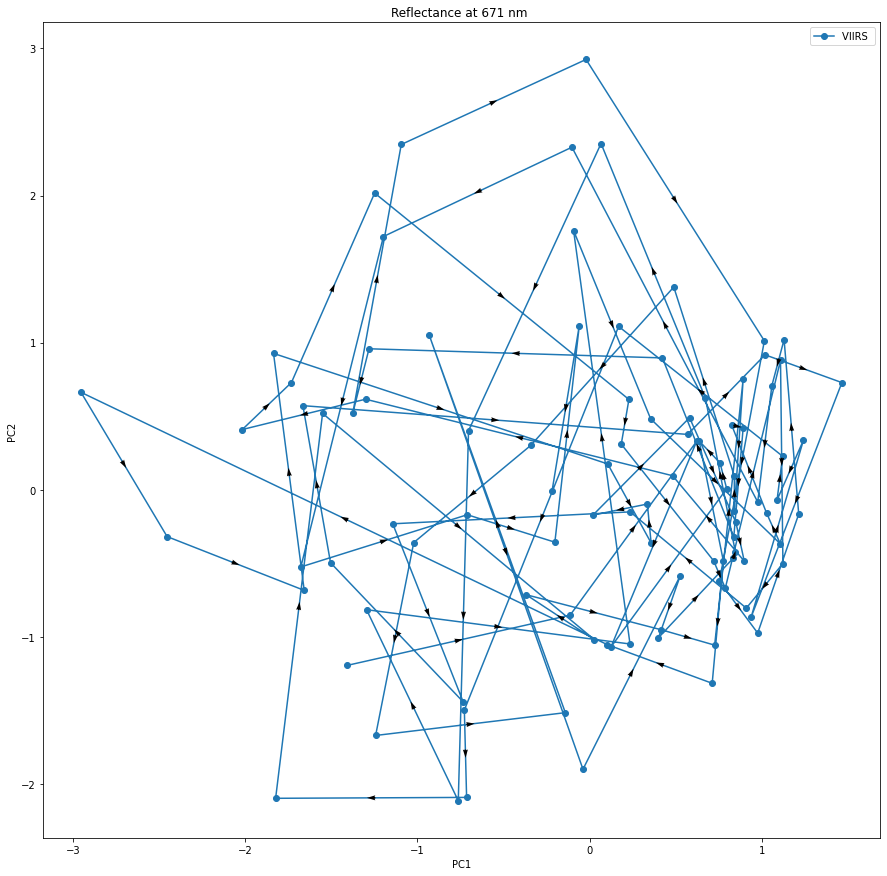

In [35]:
#from google.colab import drive
#drive.mount('/content/gdrive')
#mydirectory = '/content/gdrive/Shared drives/BFK_BOG/SURF_UG/Benny/Images/Phytoplankton_averages'
from netCDF4 import Dataset as NetCDFFile
import numpy as np
from datetime import date
from datetime import datetime as dt
import requests
import matplotlib
#The following dictionary lists the dataset IDs associated with each variable. This will allow me to loop through all the satellites that have data for the variable
monthly_data_dict ={
    'Chlorophyll':['erdMH1chlamday', 'erdVH2018chlamday'],
    'k490':['erdMH1kd490mday', 'erdVH2018k490mday'],
    'par':['erdMH1par0mday', 'erdVH2018parmday'],
    'cflh':['erdMH1cflhmday'],
    'pic':['erdVH2018picmday'],
    'poc':['erdVH2018pocmday'],
    'r671':['erdVH2018r671mday']
}
variableslist = ['Chlorophyll', 'k490', 'par', 'cflh', 'pic', 'poc', 'r671'] #creating a list of variables that I'll loop through
PCs = {} # I'm creating a dictionary with the Principal Components for statistical analysis later
for variable in variableslist: #looping through all the variables
  PCs[variable]={} # The data will be organized in this dictionary by variable and satellite. Thus I need to create sub-dictionaries for each variable within the PCs dictionary
  plt.figure(figsize=(15,15)) #need to do this outside of the for loop through monthly_data_dict[variable] or else it won't print the MODIS & VIIRS data together
  tt = 'monthly' #just doing this for monthly data right now. Could update the program in the future to deal with 8 Day or 1 Day, in which case I would need some conditional statements to determine tt based on the dataset ID (I would also need to change the monthly_data_dict)
  #the following conditionals define some variables that are useful for plotting and creating the url, depending on which variable I'm trying to analyze and which satellite it comes from
  for k in monthly_data_dict[variable]:
    if 'MH' in k:
      start_date = date(2003, 1, 16)
      end_date = date(2020, 5, 16)
      thecolor = 'cyan'
      satellite = 'MODIS '
    elif 'VH' in k:
      start_date = date(2012, 1, 15)
      end_date = date(2020, 4, 15)
      satellite = 'VIIRS '
      thecolor = 'magenta'
    if variable == 'Chlorophyll':
      if 'MH' in k:
        myvar = 'chlorophyll'
      elif 'VH' in k:
        myvar = 'chla'
      unit = 'mg m^-3'
      title = 'Chlorophyll a '
    elif variable == 'k490':
      unit = 'm^-1'
      title = 'K490 '
      myvar = 'k490'
    elif variable == 'par':
      myvar = 'par'
      unit = 'einstein m^-2 day ^-1'
      title = 'PAR '
    elif variable == 'cflh':
      myvar = 'cflh'
      unit = 'W m^-2 um^-1 sr^-1'
      title = 'Fluorescence Line Height '
    elif variable == 'pic':
      myvar = 'pic'
      unit = 'mol m^-3'
      title = 'Particulate Inorganic Carbon '
    elif variable == 'poc':
      myvar = 'poc'
      unit = 'mg m^-3'
      title = 'Particulate Organic Carbon '
    elif variable == 'r671':
      myvar = 'r671'
      unit = 'sr^-1'
      title = 'Reflectance at 671 nm '
    #making the url and opening the dataset:
    url = 'https://pricaimcit.services.brown.edu/erddap/griddap/'+k+'.nc?'+myvar+'[('+str(start_date)+'):1:('+str(end_date)+')][(41.5):1:(40.5)][(-72.65):1:(-70.25)]'
    r = requests.get(url, allow_redirects=True)
    open('test.nc', 'wb').write(r.content)
    nc = NetCDFFile('test.nc')
    nc
    #defining some of the dataset variables:
    lat = nc.variables['latitude'][:]
    lon = nc.variables['longitude'][:]
    time = nc.variables['time'][:]
    mapvar = nc.variables[myvar][:]
    coslat = np.cos(np.deg2rad(lat)).clip(0., 1.) #weighting
    wgts = np.sqrt(coslat)[..., np.newaxis] #weighting
    solver = Eof(mapvar, weights = wgts) #making the Eof solver
    pc1 = solver.pcs(npcs=2, pcscaling=1) #solving for the Principal Components. By the way,  I'm not sure. what pscaling=1 means. I got this line from this page on the documentation website: https://ajdawson.github.io/eofs/latest/examples/elnino_standard.html
    #this link helped me figure out how to put the arrows on the plot: https://stackoverflow.com/questions/58342419/show-direction-arrows-in-a-scatterplot
    PCs[variable][satellite[:-1]] = pc1 # Loading the data into PCs to use later
    x_difference = np.diff(pc1[:, 0])
    x_position = pc1[:, 0][:-1] + x_difference/2
    y_difference = np.diff(pc1[:, 1])
    y_position = pc1[:, 1][:-1] + y_difference/2
    norm = np.sqrt(x_difference**2+y_difference**2)
    plt.plot(pc1[:, 0], pc1[:, 1], marker='o', label=satellite, zorder=0) #pc1[:, 0] is the first principal component at all times, while pc1[:, 1] is the second principal component at all times
    plt.quiver(x_position, y_position, x_difference/norm, y_difference/norm, angles='xy', pivot='mid', scale=100)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
  plt.title(title)
  plt.legend(loc='best')
  #plt.savefig(f"{mydirectory}/"+variable+" PC_vs.png")
  plt.show()

## **Probability Angular Momentum (PAM) Analysis**

### I think these were already normalized by the eofs module?? But I could check to make sure the normalization is being done correctly by eofs

Multiplying a list by a number just makes a longer list with repeats of the original list, while multiplying a numpy array by a number multiplies every entry in the array by that number

In [124]:
# plt.plot(PCs['cflh']['MODIS'][:, 0], PCs['cflh']['MODIS'][:, 1], 'o')
def PAM_histograms(T):
  colors = {
    'MODIS': 'm', 
    'VIIRS': 'c'
  }
  for variable in PCs.keys():
    plt.figure(figsize=[10, 10])
    for satellite in PCs[variable].keys():
      x1 = np.array(PCs[variable][satellite][:, 0])
      x2 = np.array(PCs[variable][satellite][:, 1])
      L = np.zeros((len(x1)-T)) # This will be the Probability Angular Momentum array
      for i in range(len(L)):
        L[i]=(x1[i]*x2[i+T]-x2[i]*x1[i+T])/T
      # I must make a histogram of L, with the bins determined as in Arin Nelson's PhD thesis, using the Freedman-Diaconis rule (see p. 47-48 of Arin's thesis)
      iqr = stats.iqr(L) # Defaults to linear interpolation, I'm not sure whether this is ideal
      n = len(L)
      w = 2*(iqr/np.cbrt(n))
      Lmax = max(L)
      Lmin = min(L)
      binNum = int(np.ceil(max([np.abs(Lmax/w), np.abs(Lmin/w)])))
      binArrayHalf = np.array([i*w for i in range(binNum+1)])
      binArrayMinus = binArrayHalf[1:]*-1
      allBins = np.concatenate((np.flip(binArrayMinus), binArrayHalf))
      plt.hist(L, bins=allBins, label=satellite)
      plt.axvline(x=np.mean(L), zorder=10, color=colors[satellite], label=satellite+' mean')
    plt.title(variable+' PAM Frequency Distribution')
    plt.ylabel('Count')
    plt.xlabel('L with one month time lag')
    plt.legend()
    plt.show()
  
def PAM_means(T_list):
  global PAM_means_dict
  PAM_means_dict = {}
  for variable in PCs.keys():
    PAM_means_dict[variable] = {}
    for satellite in PCs[variable].keys():
      x1 = np.array(PCs[variable][satellite][:, 0])
      x2 = np.array(PCs[variable][satellite][:, 1])
      Lmeans = []
      for T in T_list:
        L = np.zeros((len(x1)-T)) # This will be the Probability Angular Momentum array
        for i in range(len(L)):
          L[i]=(x1[i]*x2[i+T]-x2[i]*x1[i+T])/T
        Lmeans.append(np.mean(L))
      PAM_means_dict[variable][satellite] = Lmeans

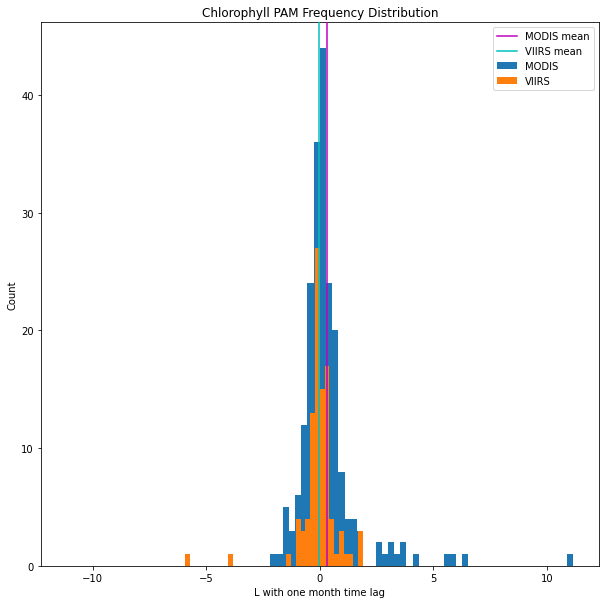

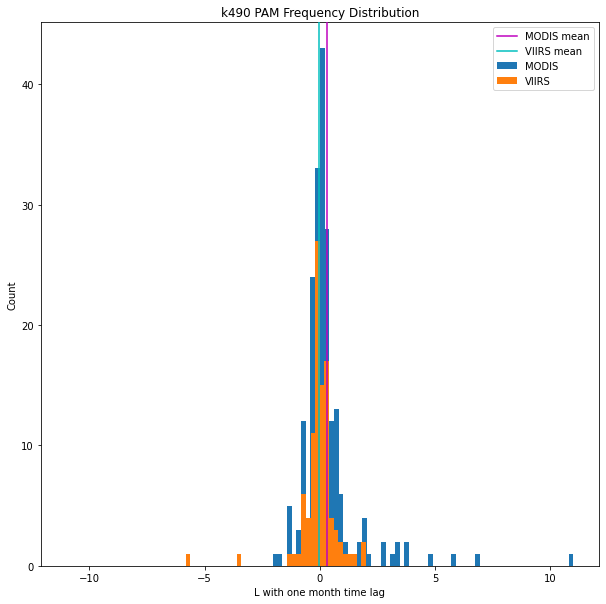

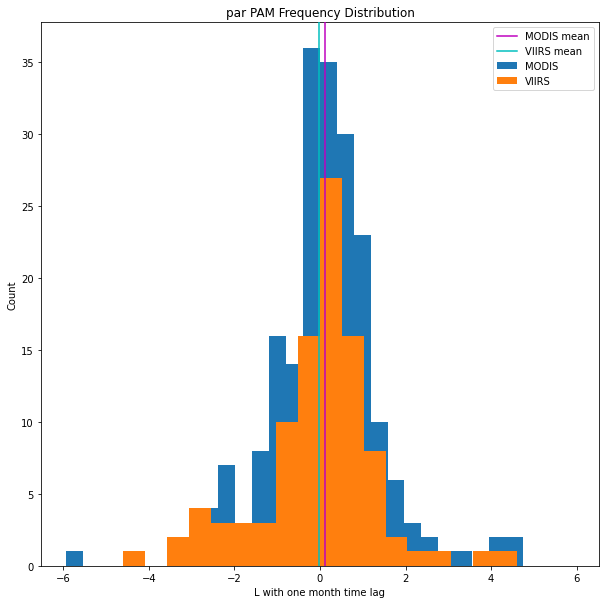

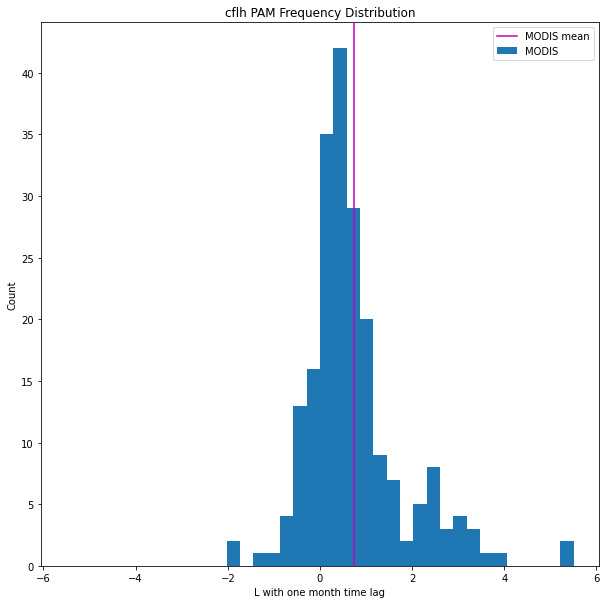

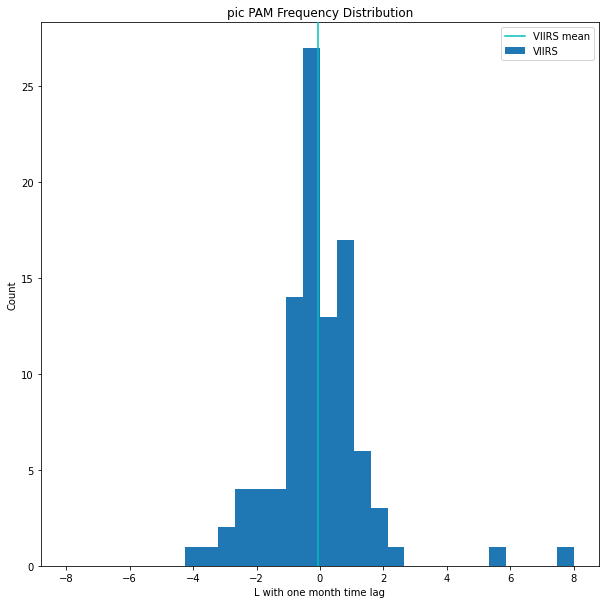

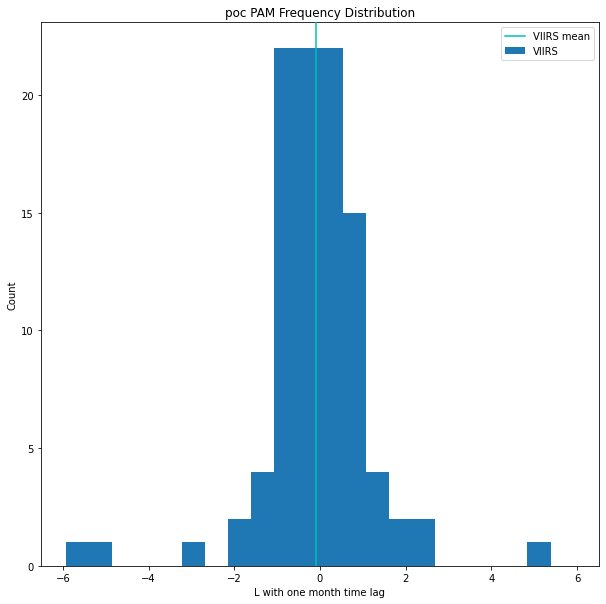

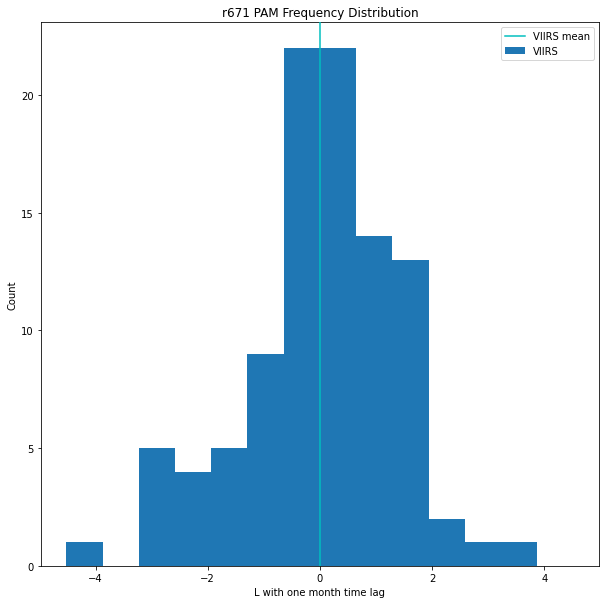

In [125]:
PAM_histograms(1)

159
50


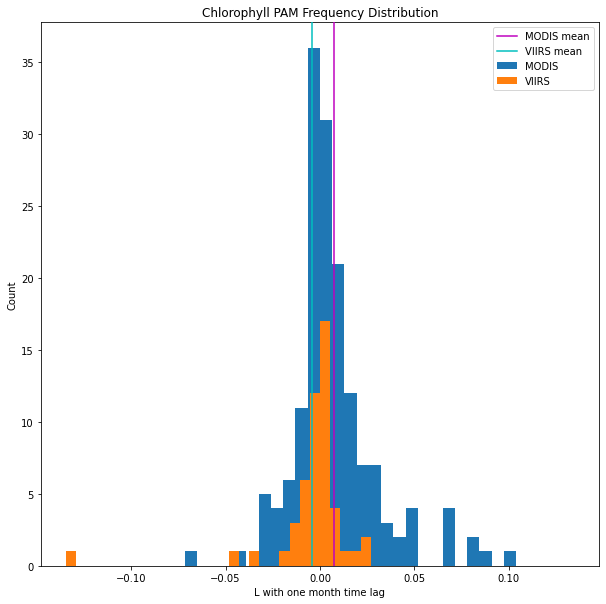

159
50


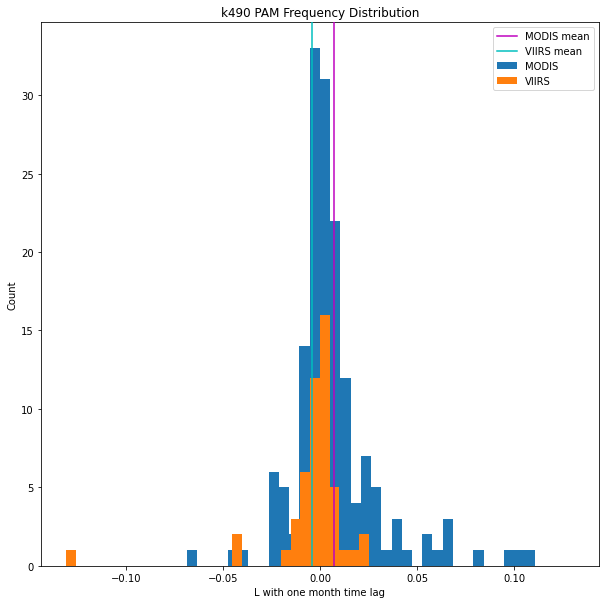

156
50


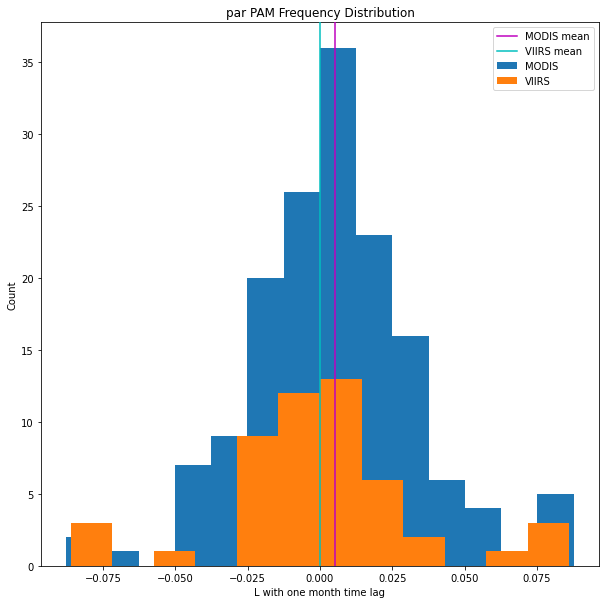

159


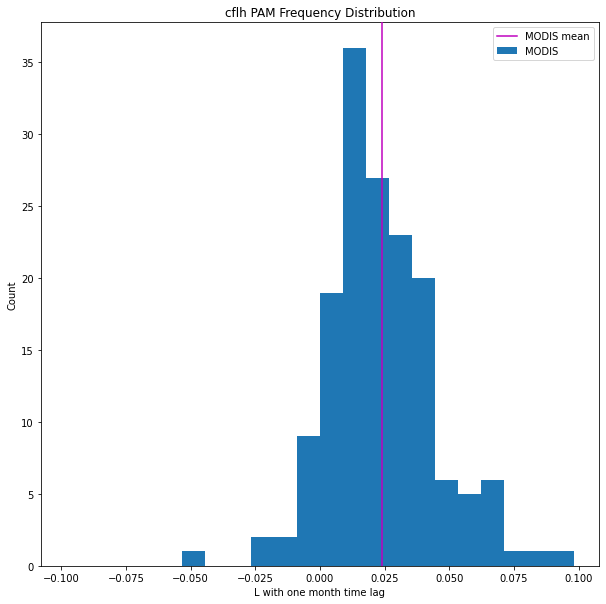

50


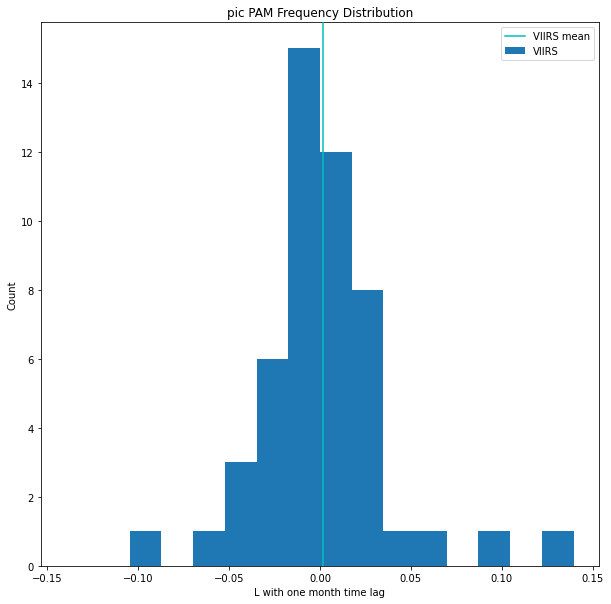

50


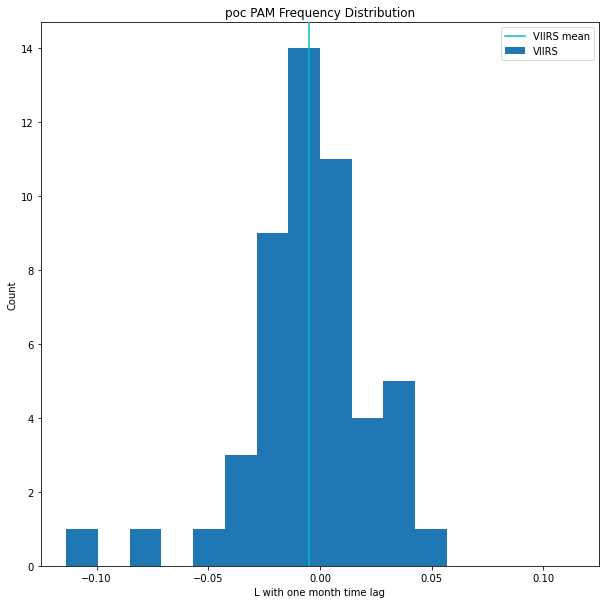

50


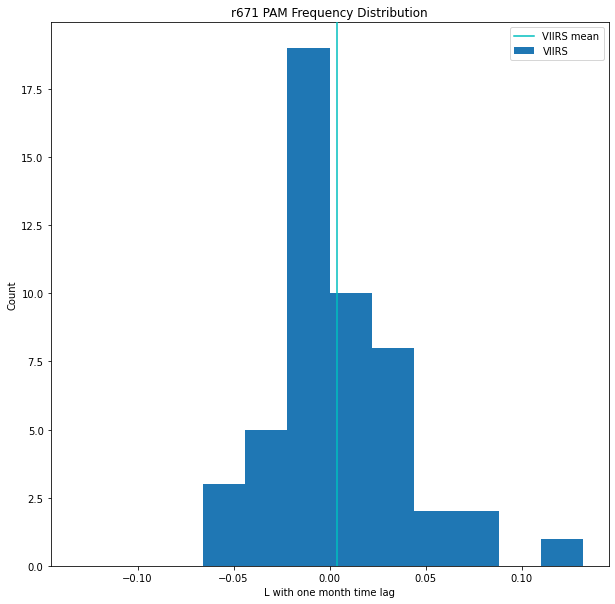

In [119]:
PAM_histograms(50)

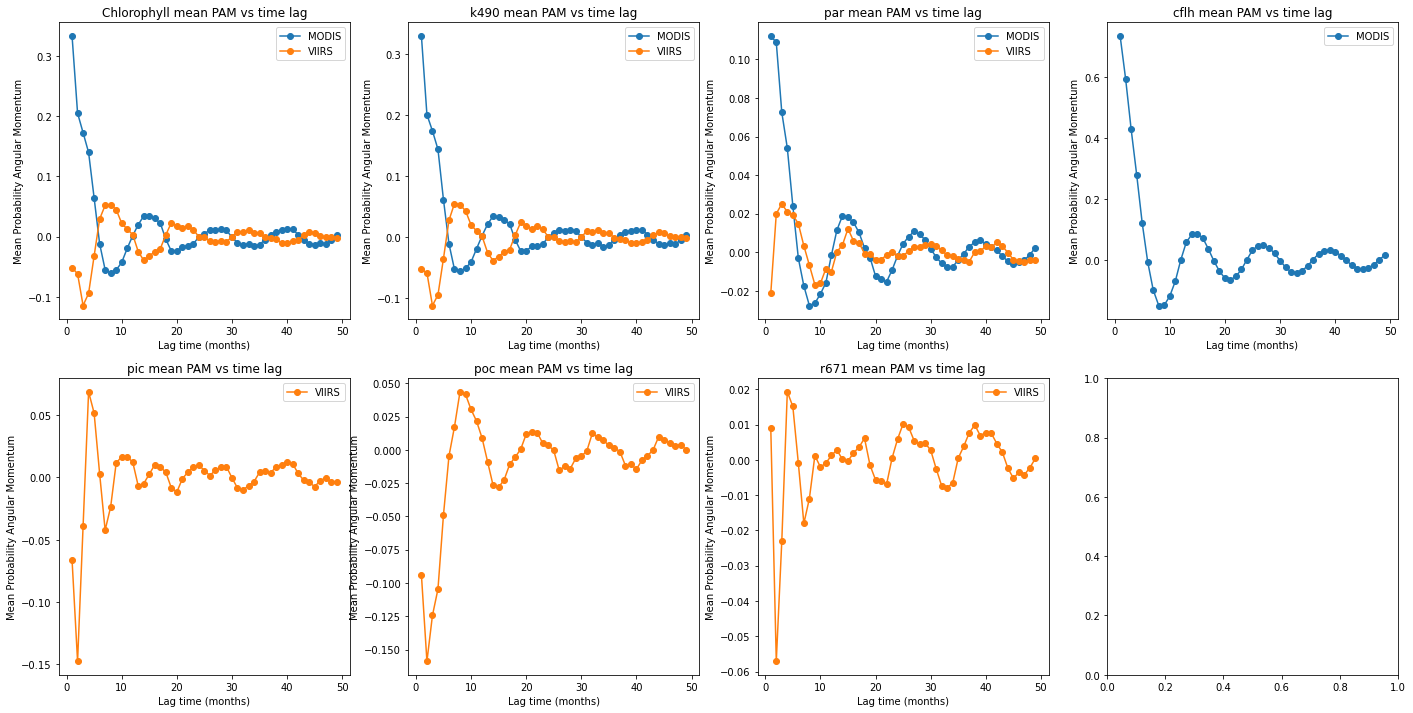

In [169]:
my_T_list = np.arange(1, 50) # How far out should I go with T-values? I think 50 seems reasonable.
PAM_means(my_T_list)
VARIABLES = list(PAM_means_dict.keys())
color_dict = {
    'MODIS': '#1f77b4',
    'VIIRS': '#ff7f0e'
}
fig, axs = plt.subplots(2, 4, figsize=[24, 12])
axlist = axs.flatten()
for i in range(7):
  for satellite in PAM_means_dict[VARIABLES[i]].keys():
    axlist[i].plot(my_T_list, PAM_means_dict[VARIABLES[i]][satellite], '-o', label=satellite, color=color_dict[satellite])
  axlist[i].set_xlabel('Lag time (months)')
  axlist[i].set_ylabel('Mean Probability Angular Momentum')
  axlist[i].set_title(VARIABLES[i]+' mean PAM vs time lag')
  axlist[i].legend()
  # plt.plot(my_T_list, PAM_means_dict['cflh']['VIIRS'], '-o')